# Respiratory Diseases Classification

Dataset: [Respiratory Sound Database(ICBHI 2017 Challenge)](https://bhichallenge.med.auth.gr/ICBHI_2017_Challenge)

---

### Outline
1. data exploration
2. pre-processing
3. train_val_test split
4. feature extraction
5. build CNN model
6. evaluate - classification report

---

## Importing Dependencies

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras import backend as K

#audio
import librosa as lb
import librosa.display as lbd
import soundfile as sf

## Data Exploration

In [3]:
patient_data = pd.read_csv('/content/drive/MyDrive/hack/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [15]:
patient_cycle = pd.read_csv('/content/drive/MyDrive/hack/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt', sep='\t', names=['start', 'end', 'crackle', 'wheeze'])
patient_cycle.head()

,start,end,crackle,wheeze
0,0.036,1.264,0,0
1,1.264,3.422,0,0
2,3.422,5.550,0,0
3,5.550,7.436,0,0
4,7.436,9.221,0,0


In [19]:
path = '/content/drive/MyDrive/hack/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files = [s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['160_1b2_Pr_mc_AKGC417L',
 '160_1b3_Lr_mc_AKGC417L',
 '160_1b3_Ar_mc_AKGC417L',
 '160_2b4_Ar_mc_AKGC417L',
 '160_1b4_Pl_mc_AKGC417L']

In [4]:
def getFilenameInfo(file):
    return file.split('_')

In [18]:
getFilenameInfo('101_1b1_Al_sc_Meditron')

['101', '1b1', 'Al', 'sc', 'Meditron']

In [19]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt', sep='\t', names=['start', 'end', 'crackles', 'wheezes'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,wheezes,pid,mode,filename
0,0.109,4.766,1,1,160,mc,160_1b2_Pr_mc_AKGC417L
1,4.766,10.342,0,1,160,mc,160_1b2_Pr_mc_AKGC417L
0,1.862,5.718,0,1,160,mc,160_1b3_Lr_mc_AKGC417L
1,5.718,9.725,0,1,160,mc,160_1b3_Lr_mc_AKGC417L
2,9.725,13.614,0,1,160,mc,160_1b3_Lr_mc_AKGC417L


In [22]:
print(patient_data.info(), '\n\n')
print(files_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB
None 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 4
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   wheezes   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB
None


In [23]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

In [37]:
data=pd.merge(files_df, patient_data, on='pid')
data.head()

,start,end,crackles,wheezes,pid,mode,filename,disease
0,0.109,4.766,1,1,160,mc,160_1b2_Pr_mc_AKGC417L,COPD
1,4.766,10.342,0,1,160,mc,160_1b2_Pr_mc_AKGC417L,COPD
2,1.862,5.718,0,1,160,mc,160_1b3_Lr_mc_AKGC417L,COPD
3,5.718,9.725,0,1,160,mc,160_1b3_Lr_mc_AKGC417L,COPD
4,9.725,13.614,0,1,160,mc,160_1b3_Lr_mc_AKGC417L,COPD


In [5]:
#data.to_csv('/content/drive/MyDrive/hack/csv_data/data.csv', index=False)
data = pd.read_csv('/content/drive/MyDrive/hack/csv_data/data.csv')
data.head()

,start,end,crackles,wheezes,pid,mode,filename,disease
0,0.109,4.766,1,1,160,mc,160_1b2_Pr_mc_AKGC417L,COPD
1,4.766,10.342,0,1,160,mc,160_1b2_Pr_mc_AKGC417L,COPD
2,1.862,5.718,0,1,160,mc,160_1b3_Lr_mc_AKGC417L,COPD
3,5.718,9.725,0,1,160,mc,160_1b3_Lr_mc_AKGC417L,COPD
4,9.725,13.614,0,1,160,mc,160_1b3_Lr_mc_AKGC417L,COPD


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

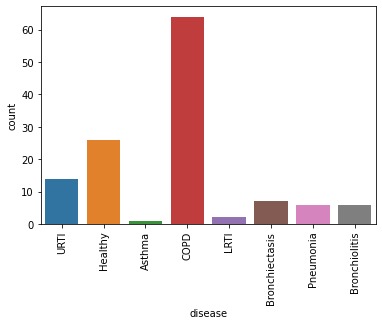

In [28]:
sns.countplot(patient_data.disease)
plt.xticks(rotation=90)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

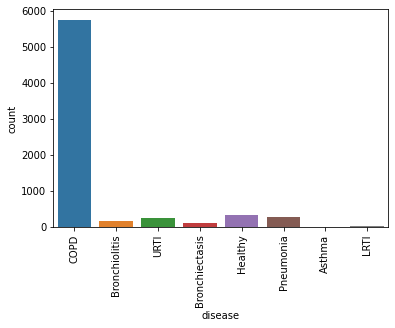

In [26]:
sns.countplot(data.disease)
plt.xticks(rotation=90)

audio_and_txt 폴더 내 txt 파일마다 기입된 호흡주기의 수가 다르기 때문에 merge 시켰을 때 data 분포에 변화가 생겼지만<br/> 여전히 **COPD**의 비율이 매우 높다.<br/>


In [6]:
def getPureSample(raw_data, start, end, sr=16000):
    max_ind = len(raw_data)
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

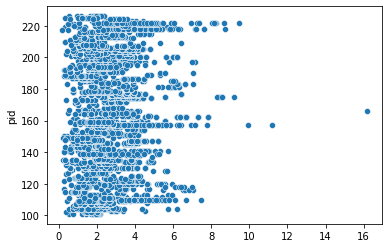

In [30]:
sns.scatterplot(x=(data.end-data.start), y=data.pid)

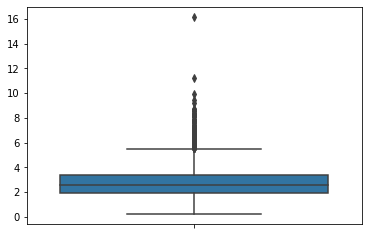

In [31]:
sns.boxplot(y=(data.end-data.start))

data 길이의 분포를 보았을 때 6초 이하로 길이를 설정하는 것이 이상적이다.<br/>
6초 보다 짧은 data의 경우 padding을 통해 길이를 맞춰줘야 한다.<br/>
note: zero padding means **silent**

## Pre-Processing

In [7]:
for index, row in data.iterrows():
    print('Index ->', index)
    print('Data ->\n', row)
    break

Index -> 0
Data ->
 start                        0.109
end                          4.766
crackles                         1
wheezes                          1
pid                            160
mode                            mc
filename    160_1b2_Pr_mc_AKGC417L
disease                       COPD
Name: 0, dtype: object


In [8]:
os.makedirs('/content/drive/MyDrive/hack/base_audio_files')

In [9]:
filename_ncwb, start_ncwb, end_ncwb, pid_ncwb, mode_ncwb, disease_ncwb, crack_wheeze_ncwb = [],[],[],[],[],[],[]

In [20]:
i,c=0,0

for index, row in data.iterrows():
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    audio_file_loc=path + filename + '.wav'

    if index > 0:
        if data.iloc[index-1]['filename']==filename:
            i+=1
    else:
        i=0

    filename=filename + '_' + str(i) + '.wav' #new filename

    filename_ncwb.append(filename)
    start_ncwb.append(row['start'])
    end_ncwb.append(row['end'])
    pid_ncwb.append(row['pid'])
    mode_ncwb.append(row['mode'])
    disease_ncwb.append(row['disease'])
    
    if row['crackles'] == 0 and row ['wheezes'] == 0:
        crack_wheeze_ncwb.append(0)
    elif row['crackles'] == 1 and row ['wheezes'] == 0:
        crack_wheeze_ncwb.append(1)
    elif row['crackles'] == 0 and row ['wheezes'] == 1:
        crack_wheeze_ncwb.append(2)
    else:
        crack_wheeze_ncwb.append(3)

    save_path='/content/drive/MyDrive/hack/base_audio_files/' + filename
    c+=1

    audioArr, sampleRate = lb.load(audio_file_loc, sr=16000)
    pureSample = getPureSample(audioArr, start, end, sampleRate)

    sf.write(file=save_path, data=pureSample, samplerate=sampleRate)

print('Total Files Processed: ', c)

Total Files Processed:  6898


In [27]:
ncwb = [filename_ncwb, start_ncwb, end_ncwb, pid_ncwb, mode_ncwb, disease_ncwb, crack_wheeze_ncwb]
processed = pd.DataFrame(ncwb)
processed = processed.transpose()
processed.columns=['filename', 'start', 'end', 'pid', 'mode', 'disease', 'crackle_wheeze']
processed.head()

,filename,start,end,pid,mode,disease,crackle_wheeze
0,160_1b2_Pr_mc_AKGC417L_0.wav,0.109,4.766,160,mc,COPD,3
1,160_1b2_Pr_mc_AKGC417L_1.wav,4.766,10.342,160,mc,COPD,2
2,160_1b3_Lr_mc_AKGC417L_1.wav,1.862,5.718,160,mc,COPD,2
3,160_1b3_Lr_mc_AKGC417L_2.wav,5.718,9.725,160,mc,COPD,2
4,160_1b3_Lr_mc_AKGC417L_3.wav,9.725,13.614,160,mc,COPD,2


In [28]:
processed.to_csv('/content/drive/MyDrive/hack/csv_data/processed.csv')

#### Zero Padding

In [23]:
sr=16000

def zero_padding(pureSample, reqLen = 6 * sr):
    padded = lb.util.pad_center(pureSample, reqLen)
    return padded

In [24]:
os.makedirs('/content/drive/MyDrive/hack/base_audio_files/zero_pad_6sec')

In [29]:
zero_padded_6sec = []

for index,row in processed.iterrows():
    maxLen=6
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    audio_file_loc= '/content/drive/MyDrive/hack/base_audio_files/' + filename
    processed_sample, _ = lb.load(audio_file_loc, sr = sr)

    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen
        processed_sample = processed_sample[int(start * sr) : int(end * sr)]

    padded_data = zero_padding(processed_sample, 6 * sr)

    save_path = '/content/drive/MyDrive/hack/base_audio_files/zero_pad_6sec/' + filename

    sf.write(file=save_path, data=padded_data, samplerate=sr)

#### 5th order Butterworth band-pass filter

In [ ]:
# # from scipy.signal import butter, sosfilt, sosfreqz

# def butter_bandpass(lowcut, highcut, fs, order=5):
#         nyq = 0.5 * fs
#         low = lowcut / nyq
#         high = highcut / nyq
#         sos = butter(order, [low, high], analog=False, btype='band', output='sos')
#         return sos

# def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#         sos = butter_bandpass(lowcut, highcut, fs, order=order)
#         y = sosfilt(sos, data)
#         return y

## Train Val Test Split


In [30]:
X_train, X_val, y_train, y_val = train_test_split(processed, processed.disease, stratify=processed.disease, random_state=42, test_size=0.2)

In [31]:
X_train.disease.value_counts()/X_train.shape[0]

COPD              0.832910
Healthy           0.046756
Pneumonia         0.041319
URTI              0.035158
Bronchiolitis     0.023197
Bronchiectasis    0.015042
LRTI              0.004712
Asthma            0.000906
Name: disease, dtype: float64

In [32]:
X_val.disease.value_counts()/X_val.shape[0]

COPD              0.833333
Healthy           0.046377
Pneumonia         0.041304
URTI              0.035507
Bronchiolitis     0.023188
Bronchiectasis    0.015217
LRTI              0.004348
Asthma            0.000725
Name: disease, dtype: float64

In [33]:
X_train.to_csv('train.csv')
X_val.to_csv('val.csv')

In [34]:
le=LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

## Feature Extraction

In [35]:
def getFeatures(path):
    soundArr, sr=lb.load(path, sr=16000)
    mSpec=lb.feature.melspectrogram(y=soundArr, sr=sr)

    return mSpec

In [36]:
root='/content/drive/MyDrive/hack/base_audio_files/zero_pad_6sec/'
mSpec_t=[]

for idx, row in X_train.iterrows():
    path=root + row['filename']
    a = getFeatures(path)
    mSpec_t.append(a)

mSpec_train=np.array(mSpec_t)

In [37]:
root='/content/drive/MyDrive/hack/base_audio_files/zero_pad_6sec/'
mSpec_v=[]

for idx, row in X_val.iterrows():
    path=root + row['filename']
    a = getFeatures(path)
    mSpec_v.append(a)

mSpec_val=np.array(mSpec_v)

In [38]:
print(mSpec_train.shape)
print(mSpec_val.shape)

(5518, 128, 188)
(1380, 128, 188)


In [39]:
os.makedirs('/content/drive/MyDrive/hack/features')

In [40]:
np.save('/content/drive/MyDrive/hack/features/mel_spec_train_6sec.npy', mSpec_train)
np.save('/content/drive/MyDrive/hack/features/mel_spec_val_6sec.npy', mSpec_val)

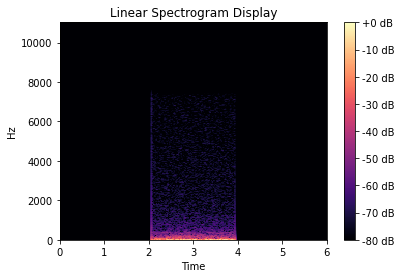

In [43]:
filepath = '/content/drive/MyDrive/hack/base_audio_files/zero_pad_6sec/'
sr = 16000
file = filepath + X_train.loc[100].filename
y, sr = lb.load(file)

D = lb.stft(y) #STFT of y
S_db = lb.amplitude_to_db(np.abs(D), ref=np.max)

#pyplot interface
# plt.figure(figsize=(10,20))
# lbd.specshow(S_db)
# plt.colorbar()

#object-oriented interface
fig, ax = plt.subplots()
img = lbd.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Linear Spectrogram Display')
fig.colorbar(img, ax=ax, format="%+2.f dB")

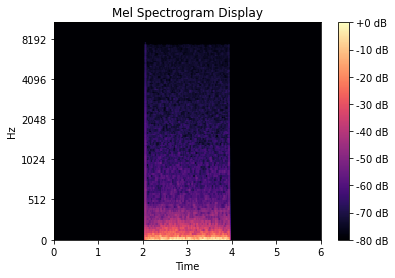

In [45]:
fig, ax = plt.subplots()
M = lb.feature.melspectrogram(y=y, sr=sr)
M_db = lb.power_to_db(M, ref=np.max)
img = lbd.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='Mel Spectrogram Display')
fig.colorbar(img, ax=ax, format="%+2.f dB")
fig.savefig('mSpec_100')

## Build Model

In [47]:
mSpec_input=keras.layers.Input(shape=(128, 188, 1), name='mSpecInput')
x=keras.layers.Conv2D(32, 5, strides=(2,3), padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)

x=keras.layers.Conv2D(64, 3, strides=(2,2), padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)

x=keras.layers.Conv2D(96, 2, padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)

x=keras.layers.Conv2D(128, 2, padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name='mSpecModel')

In [48]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 188, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 63, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 64, 63, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 63, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        1

In [49]:
os.makedirs('/content/drive/MyDrive/hack/checkpoints')

In [50]:
filepath = '/content/drive/MyDrive/hack/checkpoints/'
my_call_backs = [
                 tf.keras.callbacks.EarlyStopping(patience=5),
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                                      patience=3, min_lr=0.0001, mode='min'),
                 tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbos=0, save_best_only=True)
]

In [51]:
accuracy='sparse_categorical_accuracy'
sparseLoss=keras.losses.SparseCategoricalCrossentropy()

K.clear_session()
mSpec_model.compile(optimizer='nadam', loss=sparseLoss, metrics=[accuracy])
K.set_value(mSpec_model.optimizer.learning_rate, 0.001)

In [52]:
from sklearn.utils.class_weight import compute_class_weight

cls_weight = compute_class_weight(class_weight='balanced',
                                  classes=np.unique(y_train),
                                  y=y_train)
cls_weight = np.sort(cls_weight)
class_weight = {}
for i in range(len(cls_weight)):
    class_weight[i] = cls_weight[i]
class_weight

{0: 0.15007615317667536,
 1: 2.673449612403101,
 2: 3.025219298245614,
 3: 3.5554123711340204,
 4: 5.388671875,
 5: 8.310240963855422,
 6: 26.528846153846153,
 7: 137.95}

In [53]:
history=mSpec_model.fit(
    mSpec_train,
    y_train,
    validation_data=(mSpec_val, y_val),
    epochs=100, verbose=1,
    callbacks=my_call_backs,
    class_weight = class_weight
)

Epoch 1/100
173/173 [==============================] - ETA: 0s - loss: 22.5353 - sparse_categorical_accuracy: 0.1774

INFO:tensorflow:Assets written to: /content/drive/MyDrive/hack/checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/hack/checkpoints/assets


173/173 [==============================] - 39s 211ms/step - loss: 22.5353 - sparse_categorical_accuracy: 0.1774 - val_loss: 3.6633 - val_sparse_categorical_accuracy: 0.3312 - lr: 0.0010
Epoch 2/100
173/173 [==============================] - ETA: 0s - loss: 18.2315 - sparse_categorical_accuracy: 0.3066

INFO:tensorflow:Assets written to: /content/drive/MyDrive/hack/checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/hack/checkpoints/assets


173/173 [==============================] - 37s 215ms/step - loss: 18.2315 - sparse_categorical_accuracy: 0.3066 - val_loss: 2.9178 - val_sparse_categorical_accuracy: 0.2370 - lr: 0.0010
Epoch 3/100
173/173 [==============================] - 35s 205ms/step - loss: 17.5558 - sparse_categorical_accuracy: 0.3451 - val_loss: 3.7033 - val_sparse_categorical_accuracy: 0.4101 - lr: 0.0010
Epoch 4/100
173/173 [==============================] - 33s 193ms/step - loss: 16.6595 - sparse_categorical_accuracy: 0.4339 - val_loss: 3.1342 - val_sparse_categorical_accuracy: 0.3942 - lr: 0.0010
Epoch 5/100
173/173 [==============================] - ETA: 0s - loss: 13.3539 - sparse_categorical_accuracy: 0.4962

INFO:tensorflow:Assets written to: /content/drive/MyDrive/hack/checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/hack/checkpoints/assets


173/173 [==============================] - 36s 211ms/step - loss: 13.3539 - sparse_categorical_accuracy: 0.4962 - val_loss: 2.0873 - val_sparse_categorical_accuracy: 0.5094 - lr: 0.0010
Epoch 6/100
173/173 [==============================] - 36s 211ms/step - loss: 13.3043 - sparse_categorical_accuracy: 0.4755 - val_loss: 2.1444 - val_sparse_categorical_accuracy: 0.4399 - lr: 0.0010
Epoch 7/100
173/173 [==============================] - ETA: 0s - loss: 12.3963 - sparse_categorical_accuracy: 0.4755

INFO:tensorflow:Assets written to: /content/drive/MyDrive/hack/checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/hack/checkpoints/assets


173/173 [==============================] - 42s 241ms/step - loss: 12.3963 - sparse_categorical_accuracy: 0.4755 - val_loss: 1.5050 - val_sparse_categorical_accuracy: 0.6261 - lr: 0.0010
Epoch 8/100
173/173 [==============================] - 35s 201ms/step - loss: 12.2696 - sparse_categorical_accuracy: 0.3902 - val_loss: 1.8774 - val_sparse_categorical_accuracy: 0.4080 - lr: 0.0010
Epoch 9/100
173/173 [==============================] - 34s 195ms/step - loss: 11.1674 - sparse_categorical_accuracy: 0.3422 - val_loss: 1.7946 - val_sparse_categorical_accuracy: 0.3971 - lr: 0.0010
Epoch 10/100
173/173 [==============================] - 34s 197ms/step - loss: 9.9173 - sparse_categorical_accuracy: 0.3643 - val_loss: 1.5452 - val_sparse_categorical_accuracy: 0.3833 - lr: 0.0010
Epoch 11/100
173/173 [==============================] - 34s 196ms/step - loss: 9.1443 - sparse_categorical_accuracy: 0.3969 - val_loss: 1.7693 - val_sparse_categorical_accuracy: 0.3790 - lr: 1.0000e-04
Epoch 12/100
173/1

In [63]:
y_pred = mSpec_model.predict(mSpec_val)

## Evaluate

In [64]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

confusion_matrix(np.argmax(y_pred, axis=1), y_val)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2, 475,   2,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,  54,   1,   0,   8,   0,   0],
       [  0,  21,  30, 617,  61,   6,  49,  49,   0],
       [  0,   0,   0,   4,   0,   0,   0,   0,   0]])

9개?

In [ ]:
target_names=['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis', 'Pheumonia', 'Bronchiolitis']

with open('/content/drive/MyDrive/hack/classification_report_zero_6sec.txt', 'w') as text_file:
    print(classification_report(y_val, np.argmax(y_pred, axis=1), target_names=target_names), file=text_file)

print(classification_report(y_val, np.argmax(y_pred, axis=1), target_names=target_names))